# Initial Setup

In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
#This method will import everything associated with SciPy, but to use it, you must work within submodules
import scipy as scipy
#This method will allow you more direct access to the linear algebra routines of SciPy
from scipy import linalg as LA


# Creating a set of example observations and the associated physics matrix G

In [2]:
m_yloc_obs, m_xvel_obs, m_xloc_obs = 9, 2, 2
m_obs = m_yloc_obs + m_xvel_obs + m_xloc_obs

n_par = 5

#First set of obs
d_yloc = np.array([55., 60., 70., 75., 85., 85., 95., 95., 75.])
t_yloc = np.array([1., 1.5, 2., 2.5, 3., 3.5, 4., 4.5, 5.])
#Second set of obs
d_xloc = np.array([200., 725.])
t_xloc = np.array([5., 6.])
#Third set of obs
d_xvel = np.array([400., 500.])

d = np.concatenate((d_yloc,d_xloc,d_xvel))
print('d: ',d)

#Ordering of the parameters: x_init, v_x_init, y_init, v_y_init, g_a
G_yloc = np.zeros((m_yloc_obs,n_par))
G_yloc[:,2] = 1
G_yloc[:,3] = t_yloc
G_yloc[:,4] = -0.5*t_yloc**2

G_xloc = np.zeros((m_xloc_obs,n_par))
G_xloc[:,0] = 1
G_xloc[:,1] = t_xloc

G_xvel = np.zeros((m_xvel_obs,n_par))
G_xvel[:,1] = 1

G = np.concatenate((G_yloc, G_xloc, G_xvel))
print('G: ', G)

d:  [ 55.  60.  70.  75.  85.  85.  95.  95.  75. 200. 725. 400. 500.]
G:  [[  0.      0.      1.      1.     -0.5  ]
 [  0.      0.      1.      1.5    -1.125]
 [  0.      0.      1.      2.     -2.   ]
 [  0.      0.      1.      2.5    -3.125]
 [  0.      0.      1.      3.     -4.5  ]
 [  0.      0.      1.      3.5    -6.125]
 [  0.      0.      1.      4.     -8.   ]
 [  0.      0.      1.      4.5   -10.125]
 [  0.      0.      1.      5.    -12.5  ]
 [  1.      5.      0.      0.      0.   ]
 [  1.      6.      0.      0.      0.   ]
 [  0.      1.      0.      0.      0.   ]
 [  0.      1.      0.      0.      0.   ]]


# Solving for the best estimates of the parameters

In [3]:
m_est = LA.solve(G.transpose()@G,G.transpose()@d)
print('m_est:', m_est)

m_est: [-2095.           465.            20.5           34.53030303
     8.78787879]


# Plotting a simulation with associated original data

Text(0, 0.5, 'y location (m)')

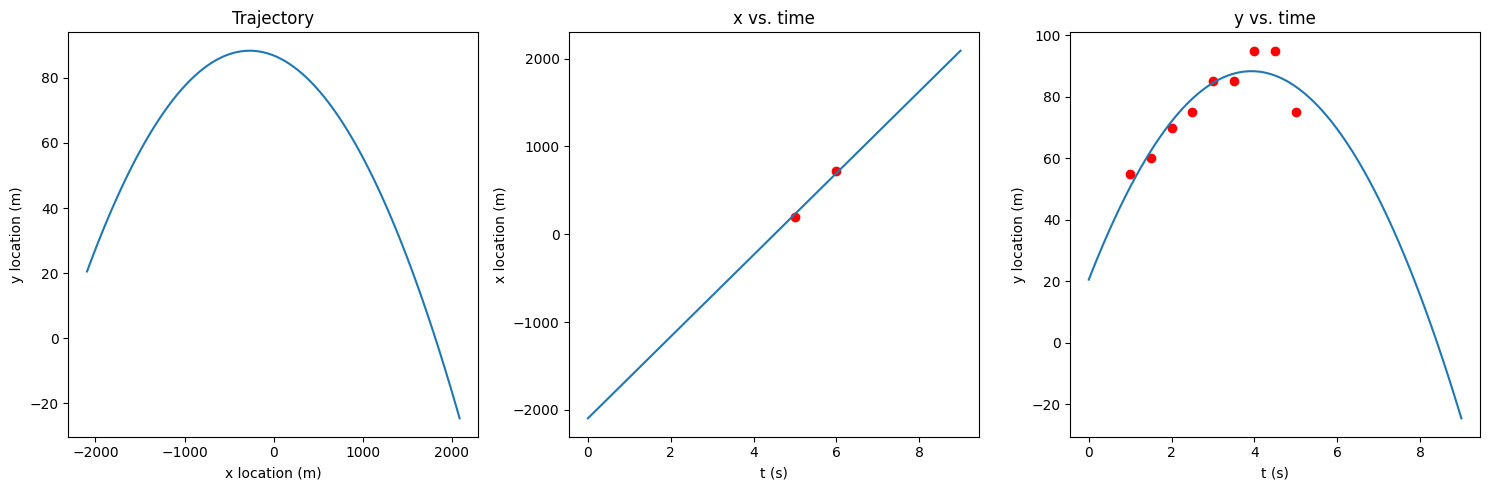

In [4]:
xinit, xvinit, yinit, yvinit, g_a = m_est
t_sim = np.linspace(0,9,100)
x_sim = xinit + xvinit*t_sim
y_sim = yinit + yvinit*t_sim - 0.5*t_sim**2*g_a

fig, axs = plt.subplots(nrows=1,ncols=3,figsize=(15,5))
fig.set_layout_engine('tight')
#Trajectory
axs[0].plot(x_sim,y_sim)
axs[0].set_title('Trajectory')
axs[0].set_xlabel('x location (m)')
axs[0].set_ylabel('y location (m)')

#X location observations
axs[1].plot(t_xloc,d_xloc,'or')
axs[1].plot(t_sim,x_sim)
axs[1].set_title('x vs. time')
axs[1].set_xlabel('t (s)')
axs[1].set_ylabel('x location (m)')

#Y location observations
axs[2].plot(t_yloc,d_yloc,'or')
axs[2].plot(t_sim,y_sim)
axs[2].set_title('y vs. time')
axs[2].set_xlabel('t (s)')
axs[2].set_ylabel('y location (m)')


# Evaluating data residuals for each data type

In [5]:
resid = d - G@m_est
print('residual: ', resid)

#Note: For problems where the number of unknowns approaches the number
# of observations, this can result in bias. 
#In most cases, however, the bias in estimating data error is undetectable
#for all practical purposes
yloc_err_est = np.sqrt(np.mean((resid[0:9])**2))
xloc_err_est = np.sqrt(np.mean((resid[9:11])**2))
xvel_err_est = np.sqrt(np.mean((resid[11:13])**2))

residual:  [  4.36363636  -2.40909091  -1.98484848  -4.36363636   0.45454545
  -2.53030303   6.68181818   8.09090909  -8.3030303  -30.
  30.         -65.          35.        ]


# Beginnings of dealing with uncertainty

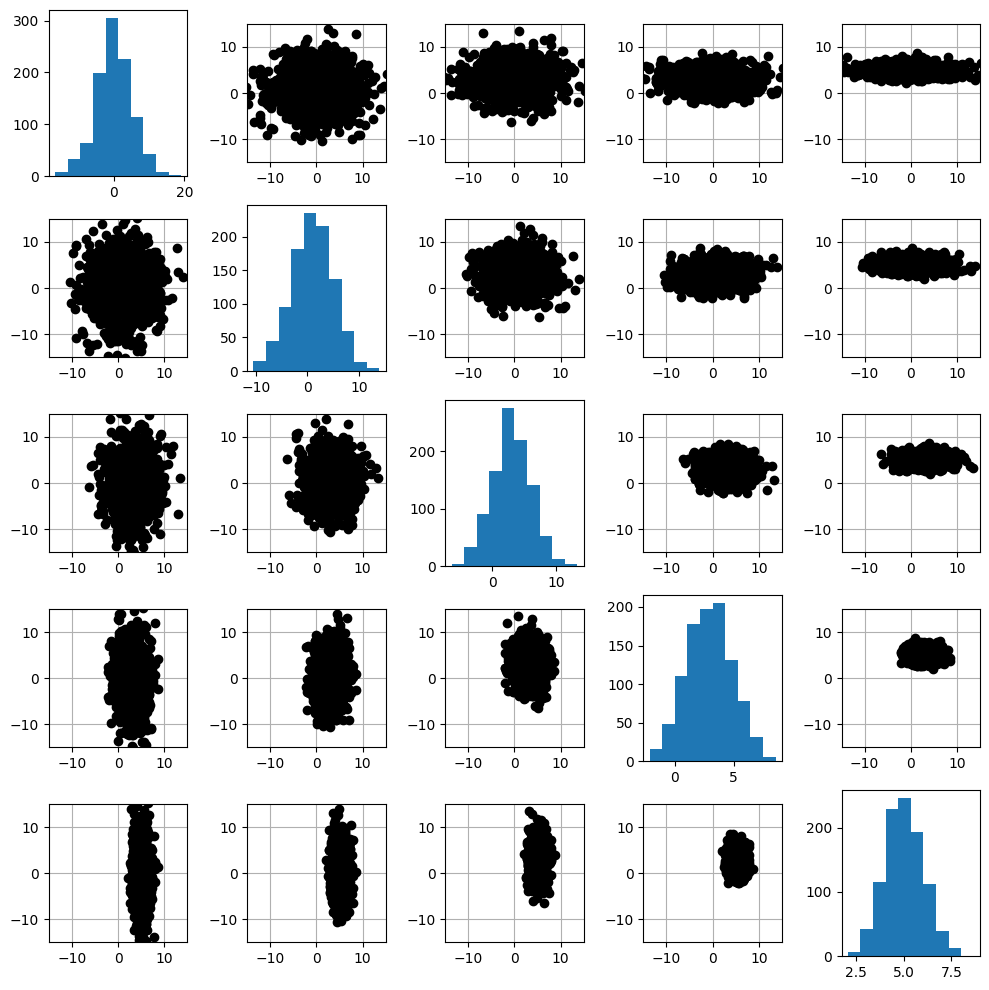

In [6]:
#TODO: Using results from class, implement weighted inversion and
#Investigate the residuals after the fact.

#Then estimate the uncertainty in each parameter

A = np.diag([25., 16., 9., 4., 1])
mean = np.array([[0.], [1.], [3.], [3.], [5.]])
fig, axs = plt.subplots(nrows=5,ncols=5,figsize=(10,10))
fig.set_layout_engine('tight')

numrelz = 1000
allrelz = np.zeros((5,numrelz))
for i in range(numrelz):
    relz = mean + (LA.cholesky(A)).transpose()@np.random.randn(5,1)
    allrelz[:,i] = np.squeeze(relz)

for p1 in range(5):
    for p2 in range(5):
        if p1 == p2:
            axs[p1,p2].hist(allrelz[p1])
        else:
            axs[p1,p2].plot(allrelz[p1,:],allrelz[p2,:],'ok')
            axs[p1,p2].set_aspect('equal')
            axs[p1,p2].set_xlim([-15,15])
            axs[p1,p2].set_ylim([-15,15])
            axs[p1,p2].grid(True)